In [1]:
!pip install pandas
!pip install tensorflow

In [2]:
!pip install tensorflow-datasets

In [3]:
import shutil 
import os
import pandas as pd

In [4]:
import os
import copy
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import glob
import numpy as np
import tensorflow as tf
from skimage.io import imread, imsave
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn import svm
from PIL import Image
import random

import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [32]:
train_dataset = '/Users/ericyao/Documents/AARD/Lung/archive/raw2_png/Training'
testing_dataset = '/Users/ericyao/Documents/AARD/Lung/archive/raw2_png/Testing'

In [33]:
data= pd.read_csv("metadata3.csv")
data

,Filename,StudyDate,BrixiaScoreGlobal,Subject,StudyId,Sex,AgeAtStudyDateFiveYear
0,15626316918619298757.png,20200403,1,P2255,A0000,M,11
1,14564261561865340756.png,20200406,2,P2291,A0001,M,8
2,3030367955559789319.png,20200405,1,P2272,A0002,M,11
3,10548672632742803246.png,20200408,3,P2299,A0003,M,12
4,434139174381164494.png,20200409,2,P2076,A0004,M,8
...,...,...,...,...,...,...,...
4690,10409101678672828001.png,20200314,1,P1071,A4582,M,10
4691,282205201992683717.png,20200318,10,P1071,A4583,M,10
4692,9504330565338059035.png,20200322,15,P0193,A4584,M,14
4693,8824145367570793429.png,20200331,16,P0193,A4585,M,14


In [34]:
img_paths = glob.glob(os.path.join(train_dataset, '*/*.png'))
parent_names = [os.path.basename(os.path.abspath(os.path.join(p, os.pardir))) for p in img_paths]
labels = np.asarray([1 if p == '1' else 2 if p == '2' 
                    else 3 for p in parent_names])
imgs = np.asarray([imread(p) for p in img_paths])
len(img_paths)

90

In [35]:
x_train, x_test, y_train, y_test = train_test_split(imgs, labels, test_size = 0.25, random_state = 1)

In [36]:
y_test

array([3, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 2, 1, 3, 2, 1, 1, 2, 2, 3, 1,
       2])

In [62]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (512,512,3)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(3,activation = "softmax")  
])

In [66]:
model = tf.keras.Model(x_in, x_out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 512, 512, 16)      64        
                                                                 
 batch_normalization (BatchN  (None, 512, 512, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 32)      544       
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128   

In [69]:
bs=32       
train_dir = "/Users/ericyao/Documents/AARD/Lung/archive/raw2_png/Training" 
validation_dir = "/Users/ericyao/Documents/AARD/Lung/archive/raw2_png/Testing"   
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator( 
    rotation_range=20,
    brightness_range=[0.2,1.0],
    featurewise_center=True,
    featurewise_std_normalization=True,
    )

test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

train_generator=train_datagen.flow_from_directory(train_dir,batch_size=bs,class_mode='categorical',target_size=(512,512))

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=bs,
                                                         class_mode  = 'categorical',
                                                         target_size=(512,512))

Found 90 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [70]:
import math

In [71]:
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / 32))

steps_per_epoch = compute_steps_per_epoch(90)
val_steps = compute_steps_per_epoch(60)

In [73]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [74]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [75]:
mc = ModelCheckpoint('Resnet.h5', monitor='val_accuracy', mode='acc')

In [76]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=60,
                    validation_steps= val_steps,
                    verbose=2,
                    callbacks=[mc, es])

Epoch 1/60
3/3 - 22s - loss: 0.5591 - acc: 0.7889 - val_loss: 1.1304 - val_acc: 0.3333 - 22s/epoch - 7s/step
Epoch 2/60
3/3 - 13s - loss: 0.5046 - acc: 0.8111 - val_loss: 1.1385 - val_acc: 0.3333 - 13s/epoch - 4s/step
Epoch 3/60
3/3 - 14s - loss: 0.6160 - acc: 0.7444 - val_loss: 1.1383 - val_acc: 0.3333 - 14s/epoch - 5s/step
Epoch 4/60
3/3 - 12s - loss: 0.5853 - acc: 0.7556 - val_loss: 1.1339 - val_acc: 0.3333 - 12s/epoch - 4s/step
Epoch 5/60


KeyboardInterrupt: 

In [54]:
scores = model.predict(validation_generator, verbose = 1)

2/2 [==============================] - 3s 998ms/step


In [55]:
model.evaluate(validation_generator, verbose = 1)

2/2 [==============================] - 3s 1s/step - loss: 1.2975 - acc: 0.3333


[1.2974728345870972, 0.3333333432674408]

In [56]:
preds = np.argmax(scores, axis = 1)

In [57]:
preds 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

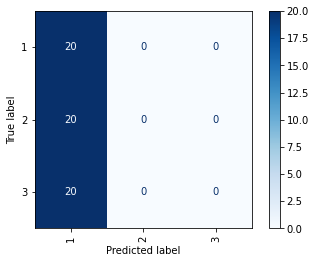

In [58]:
matrix = confusion_matrix(validation_generator.classes, preds)
disp = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = train_generator.class_indices)
disp = disp.plot(cmap = plt.cm.Blues)
plt.xticks(rotation = 90)
plt.show()

In [60]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[0].set(xlim=(0, 80), ylim=(0, 2))
    ax[0].set_xlabel('Epochs')
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[1].set(xlim=(0, 80), ylim=(0, 1))
    ax[1].set_xlabel('Epochs')
    ax[0].legend()
    ax[1].legend()

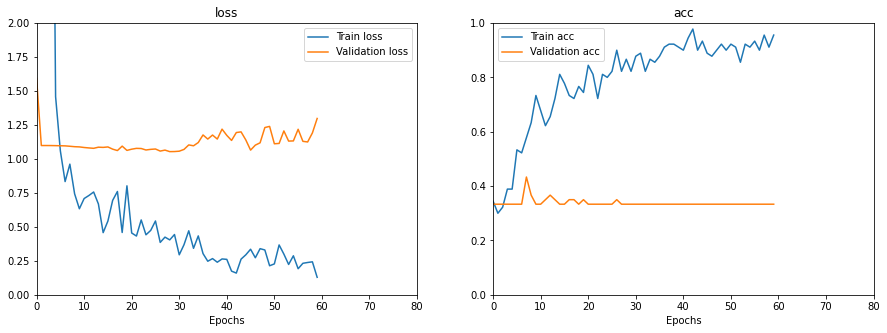

In [61]:
show_final_history(history)